<a href="https://colab.research.google.com/github/Divyaa2645/social_review/blob/main/SENTIMENT_ANALYSIS_FOR_TELEGRAM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import datetime  # Import the datetime module

import warnings
warnings.filterwarnings("ignore")

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# Define a color palette
color_palette = sns.color_palette("plasma") # You can change 'viridis' to other palettes
sns.set_palette(color_palette) # Setting the color palette for seaborn

In [3]:
# Load the dataset
df = pd.read_csv("telegram_data.csv")
df.head().style.background_gradient(cmap='plasma')



,Unnamed: 0,channel,id,text,date,views,scores,compound,sentiment_type
0,0,binancesignals,1382,bitcoin market cap surpasses 13 trillion,2024-03-04 15:33:04+00:00,6319.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000000,NEUTRAL
1,1,binancesignals,1381,update atausdt long leverage cross x10 smashed second target reached 600 profit using x10 leverage ð,2024-03-04 10:48:51+00:00,6847.000000,"{'neg': 0.0, 'neu': 0.751, 'pos': 0.249, 'compound': 0.5106}",0.510600,POSITIVE
2,2,binancesignals,1380,altcoins started make move bitcoin total market cap hit 14month high altseason finally hereðð,2024-03-03 18:53:52+00:00,8066.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000000,NEUTRAL
3,3,binancesignals,1379,coin maticusdt timeframe 1d observation broken major horizontal level resistance went retest expecting see large movement upside one first target would 12,2024-03-03 16:52:07+00:00,7740.000000,"{'neg': 0.129, 'neu': 0.871, 'pos': 0.0, 'compound': -0.4767}",-0.476700,NEGATIVE
4,4,binancesignals,1378,coin aptusdt timeframe 1d observation broken major horizontal level resistance went liquidity grab expecting see pullback upside 15,2024-03-03 16:50:49+00:00,7668.000000,"{'neg': 0.154, 'neu': 0.846, 'pos': 0.0, 'compound': -0.4767}",-0.476700,NEGATIVE


In [4]:
df.describe().style.background_gradient(cmap='tab20c')

,Unnamed: 0,id,views,compound
count,14712.000000,14712.000000,14712.000000,14712.000000
mean,7695.078915,5731.983415,14737.631525,0.323880
std,4430.002318,3185.394956,12069.131738,0.468967
min,0.000000,7.000000,39.000000,-0.956500
25%,3825.750000,2620.500000,7513.750000,0.000000
50%,7702.500000,6559.000000,11528.000000,0.440400
75%,11527.250000,8412.000000,21654.250000,0.765000
max,15358.000000,10554.000000,375298.000000,0.995800


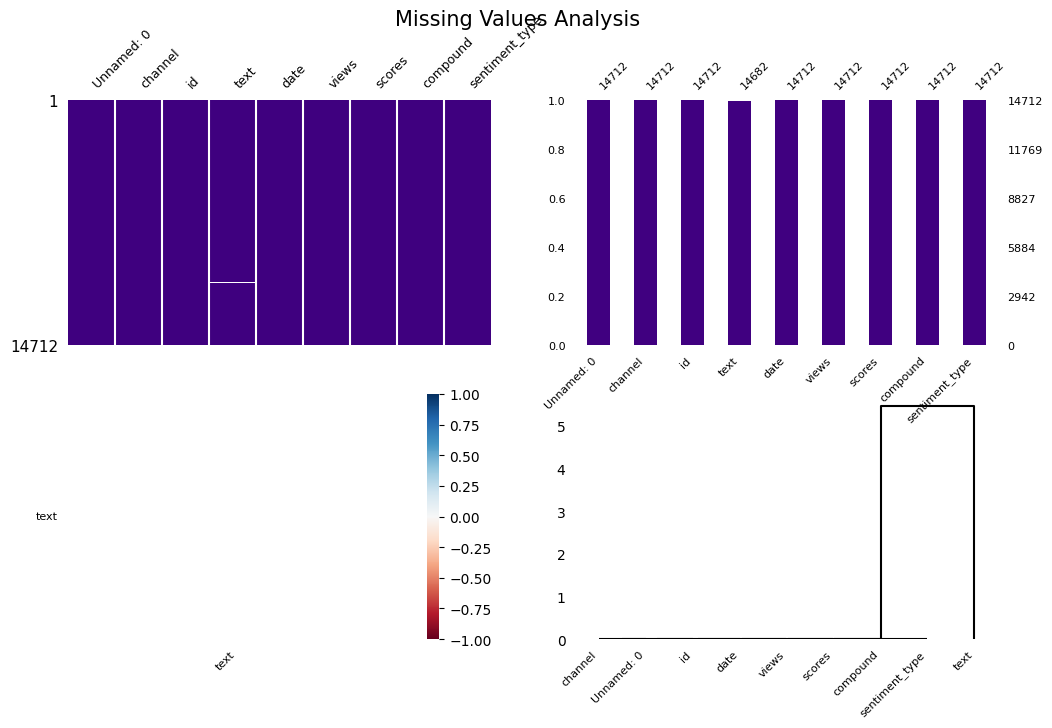

In [5]:
import missingno as msno

fig, ax = plt.subplots(2,2,figsize=(12,7))
axs = np.ravel(ax)
msno.matrix(df,  fontsize=9, color=(0.25,0,0.5),ax=axs[0]);
msno.bar(df, fontsize=8, color=(0.25,0,0.5), ax=axs[1]);
msno.heatmap(df,fontsize=8,ax=axs[2]);
msno.dendrogram(df,fontsize=8,ax=axs[3], orientation='top')

fig.suptitle('Missing Values Analysis', y=1.01, fontsize=15)

# Save the plot
plt.savefig('missing_values_analysis.png')

# Show the plot
plt.show()

In [6]:
def clean_text(text):
    """
    Cleans the input text by removing special characters, URLs, and converting to lowercase.
    """
    if isinstance(text, str):  # Check if the input is a string
        text = re.sub(r'http\S+|www\S+|@\S+', '', text, flags=re.MULTILINE) # Remove URLs and mentions
        text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove special characters and numbers
        text = text.lower() # Convert to lowercase
        return text
    else:
        return ""  # Return an empty string for non-string values

df['cleaned_text'] = df['text'].apply(clean_text)
print(df[['text', 'cleaned_text']].head())

def preprocess_text(text):
    """
    Tokenizes, removes stopwords, and lemmatizes the input text.
    """
    # Tokenize the text
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    # Join the words back into one string
    return ' '.join(words)

df['processed_text'] = df['cleaned_text'].apply(preprocess_text)
print(df[['cleaned_text', 'processed_text']].head())

                                                text  \
0           bitcoin market cap surpasses 13 trillion   
1  update atausdt long leverage cross x10 smashed...   
2  altcoins started make move bitcoin total marke...   
3  coin maticusdt timeframe 1d observation broken...   
4  coin aptusdt timeframe 1d observation broken m...   

                                        cleaned_text  
0           bitcoin market cap surpasses    trillion  
1  update atausdt long leverage cross x   smashed...  
2  altcoins started make move bitcoin total marke...  
3  coin maticusdt timeframe  d observation broken...  
4  coin aptusdt timeframe  d observation broken m...  
                                        cleaned_text  \
0           bitcoin market cap surpasses    trillion   
1  update atausdt long leverage cross x   smashed...   
2  altcoins started make move bitcoin total marke...   
3  coin maticusdt timeframe  d observation broken...   
4  coin aptusdt timeframe  d observation broken m... 

In [7]:
# Handling Missing Values
print("Missing values before handling:")
df.isnull().sum()



Missing values before handling:


,0
Unnamed: 0,0
channel,0
id,0
text,30
date,0
views,0
scores,0
compound,0
sentiment_type,0
cleaned_text,0


In [8]:
# For simplicity, I'll fill missing text with an empty string
df['text'] = df['text'].fillna('')
df['processed_text'] = df['processed_text'].fillna('')
print("\nMissing values after handling:")
df.isnull().sum()


Missing values after handling:


,0
Unnamed: 0,0
channel,0
id,0
text,0
date,0
views,0
scores,0
compound,0
sentiment_type,0
cleaned_text,0



Sentiment Distribution:
 sentiment_type
POSITIVE    8789
NEUTRAL     3879
NEGATIVE    2044
Name: count, dtype: int64


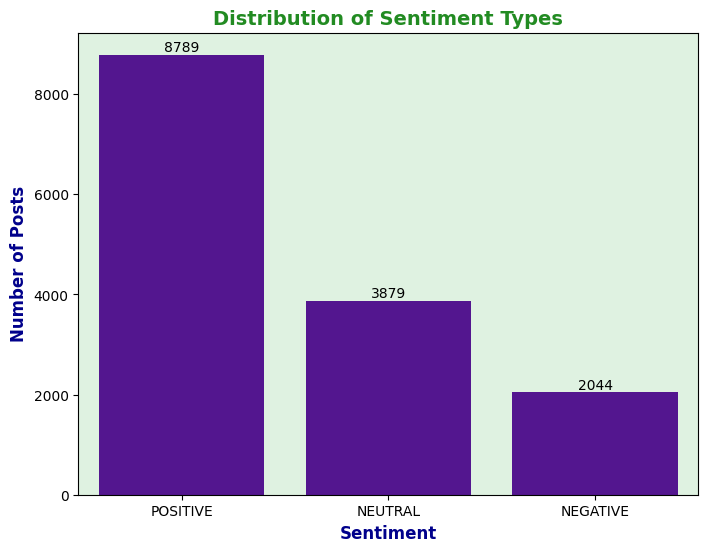

In [9]:
# Sentiment Distribution
sentiment_counts = df['sentiment_type'].value_counts()
print("\nSentiment Distribution:\n", sentiment_counts)
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiment Types', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
plt.xlabel('Sentiment',fontsize = 12, fontweight = 'bold', color = 'darkblue')
plt.ylabel('Number of Posts',fontsize = 12, fontweight = 'bold', color = 'darkblue')
plt.gca().set_facecolor('#dff2e1')

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()


Most Common Words: [('vip', 8531), ('market', 5609), ('binance', 5335), ('target', 5105), ('bitcoin', 4529), ('trading', 3812), ('killer', 3811), ('x', 3571), ('profit', 3527), ('level', 3410), ('update', 3284), ('btc', 3222), ('bullet', 3124), ('top', 2906), ('h', 2671), ('move', 2421), ('crypto', 2418), ('content', 2267), ('price', 2156), ('long', 2148)]


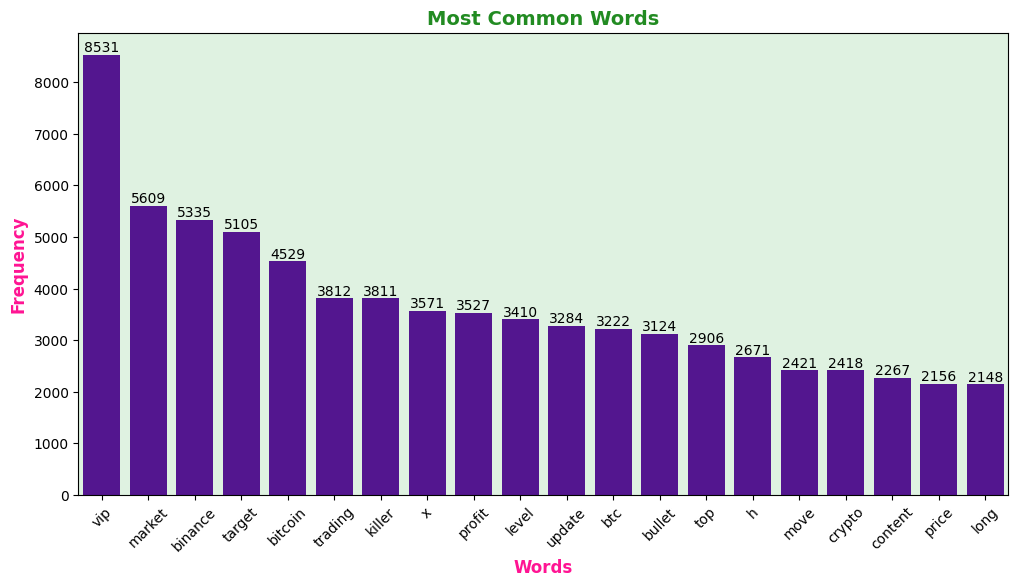

In [10]:
# Most Common Words
def plot_most_common_words(text_series, top_n=20):
    """
    Plots the most common words in a text series.
    """
    all_words = ' '.join(text_series).split()
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(top_n)
    print("Most Common Words:", most_common_words)
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=list(words), y=list(counts))
    plt.xticks(rotation=45)
    plt.title('Most Common Words', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
    plt.xlabel('Words',fontsize = 12, fontweight = 'bold', color = 'deeppink')
    plt.ylabel('Frequency',fontsize = 12, fontweight = 'bold', color = 'deeppink')
    plt.gca().set_facecolor('#dff2e1')

    #Add values to the  most common words
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plt.show()

plot_most_common_words(df['processed_text'])


Sentiment Distribution by Channel:
 sentiment_type          NEGATIVE  NEUTRAL  POSITIVE
channel                                            
BitcoinBullets               285     1216      2291
CryptoScanner100eyes           0      249       344
VerifiedCryptoNews           149      222       450
binancekillers               427     1116      3732
binancesignals               704      642      1136
universalcryptosignals         4        0        13
wolfoftrading                475      434       823


<Figure size 1200x600 with 0 Axes>

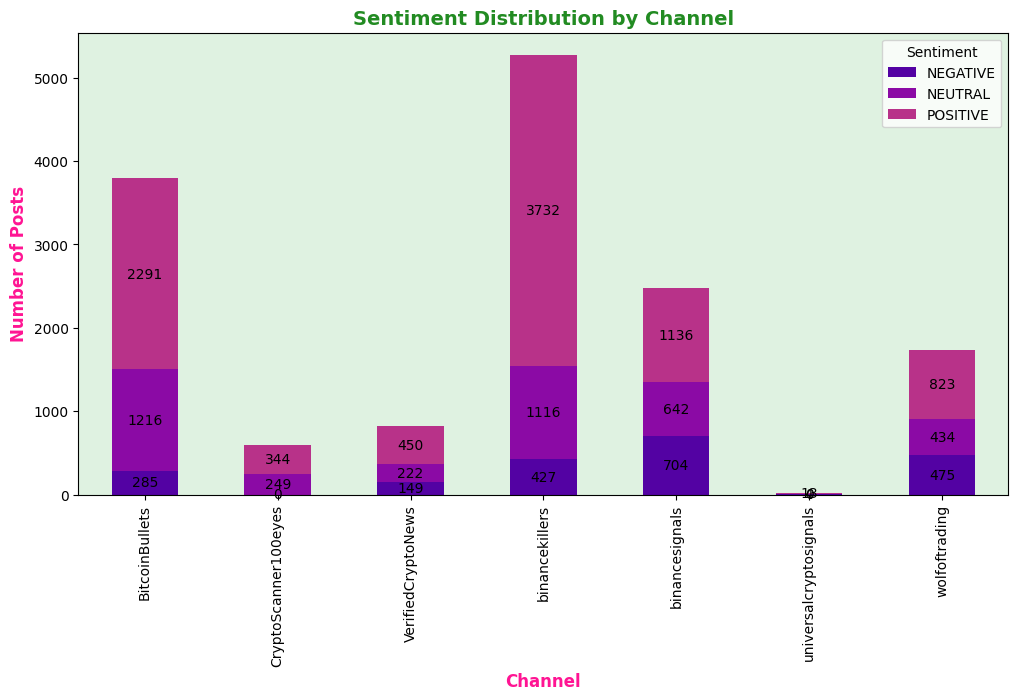

In [11]:
# Sentiment Distribution by Channel
channel_sentiment = df.groupby('channel')['sentiment_type'].value_counts().unstack(fill_value=0)
print("Sentiment Distribution by Channel:\n", channel_sentiment)
plt.figure(figsize=(12, 6))
ax = channel_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution by Channel', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
plt.xlabel('Channel',fontsize = 12, fontweight = 'bold', color = 'deeppink')
plt.ylabel('Number of Posts',fontsize = 12, fontweight = 'bold', color = 'deeppink')
plt.legend(title='Sentiment')
plt.gca().set_facecolor('#dff2e1')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.0f}', (x + width/2, y + height/2),
                ha='center', va='center', xytext=(0, 0), textcoords='offset points', color='black')

plt.show()


Daily Sentiment Counts:
 sentiment_type  NEGATIVE  NEUTRAL  POSITIVE
date                                       
2022-12-01             0        1         4
2022-12-02             1        2         7
2022-12-03             3        1        15
2022-12-04             3        5         7
2022-12-05             2        6         6


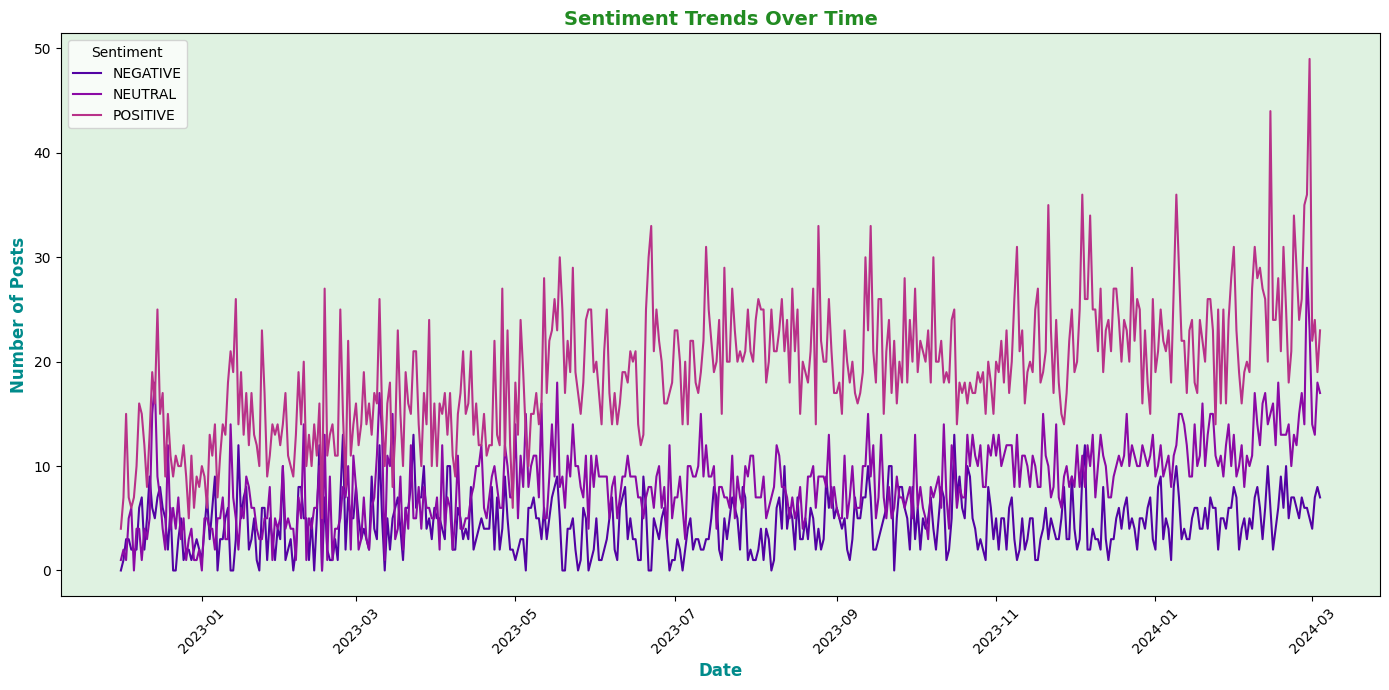

In [12]:
# Sentiment Trends Over Time
# Convert 'date' to datetime objects, handling potential parsing issues
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# If 'date' column has any NaT values (failed parsing), handle them
df = df.dropna(subset=['date'])

# Group by date and sentiment type
daily_sentiment = df.groupby([df['date'].dt.date, 'sentiment_type']).size().unstack(fill_value=0)
print("Daily Sentiment Counts:\n", daily_sentiment.head())
# Plot sentiment trends over time
daily_sentiment.plot(figsize=(14, 7))
plt.title('Sentiment Trends Over Time', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
plt.xlabel('Date',fontsize = 12, fontweight = 'bold', color = 'darkcyan')
plt.ylabel('Number of Posts',fontsize = 12, fontweight = 'bold', color = 'darkcyan')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)  # Rotate date labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.gca().set_facecolor('#dff2e1')
plt.show()


In [13]:
#  Word Cloud Visualization
def generate_word_cloud(text):
    """
    Generates and displays a word cloud from the given text.
    """
    # Check if the text list is empty
    if not text:
        print("No text available to generate word cloud.")
        return None  # Return None if no text

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Social Media Posts', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
    plt.gca().set_facecolor('#dff2e1')
    plt.show()
    return True # return True if wordcloud is generated

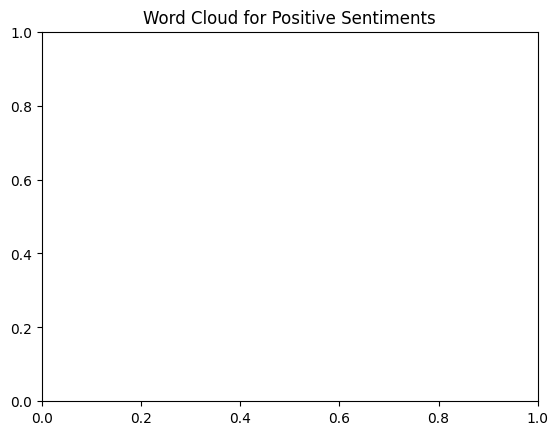

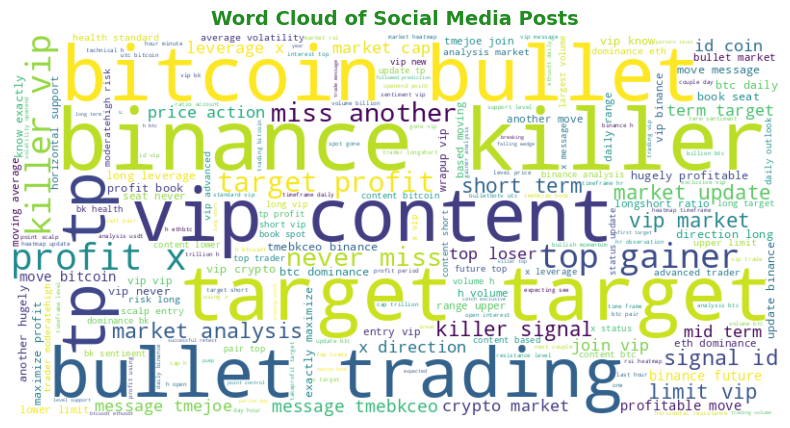

Positive Word Cloud Generated


In [14]:
# Positive Words Cloud
positive_text = df[df['sentiment_type'] == 'POSITIVE']['processed_text'].tolist() # Convert series to list
plt.title('Word Cloud for Positive Sentiments')
if generate_word_cloud(positive_text):
    print("Positive Word Cloud Generated")
else:
    print("No positive sentiment data available.")


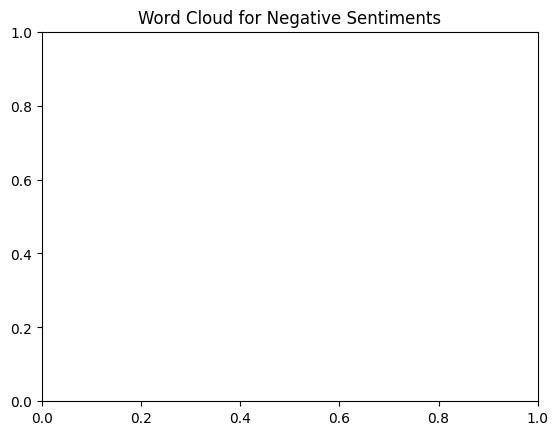

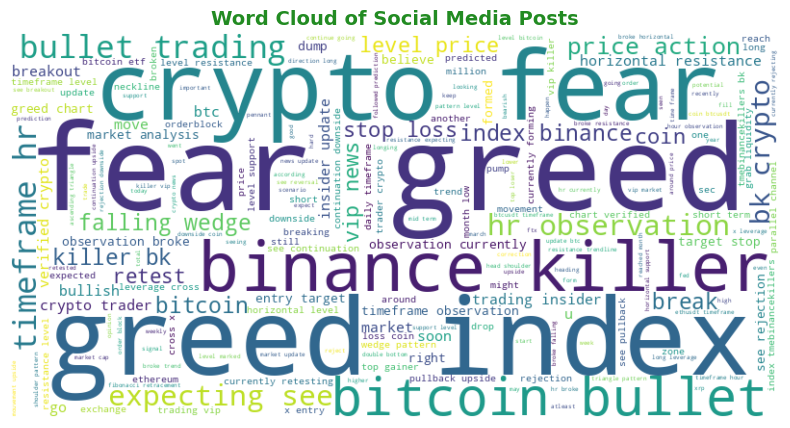

Negative Word Cloud Generated


In [15]:
# Negative Words Word Cloud
negative_text = df[df['sentiment_type'] == 'NEGATIVE']['processed_text'].tolist() # Convert series to list
plt.title('Word Cloud for Negative Sentiments')
if generate_word_cloud(negative_text):
    print("Negative Word Cloud Generated")
else:
    print("No negative sentiment data available.")


Average Views per Sentiment:
 sentiment_type
NEGATIVE    15733.133072
NEUTRAL     13376.656097
POSITIVE    15106.776880
Name: views, dtype: float64


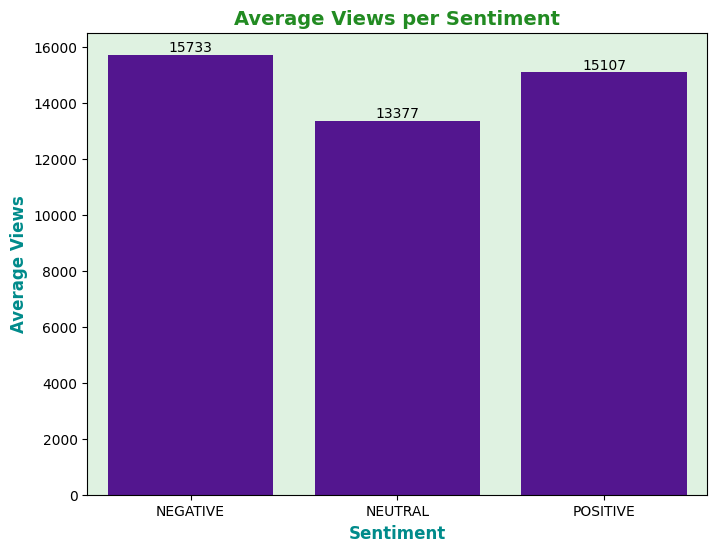

In [16]:
# Average Views per Sentiment
avg_views_sentiment = df.groupby('sentiment_type')['views'].mean()
print("\nAverage Views per Sentiment:\n", avg_views_sentiment)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=avg_views_sentiment.index, y=avg_views_sentiment.values)
plt.title('Average Views per Sentiment', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
plt.xlabel('Sentiment',fontsize = 12, fontweight = 'bold', color = 'darkcyan')
plt.ylabel('Average Views',fontsize = 12, fontweight = 'bold', color = 'darkcyan')
plt.gca().set_facecolor('#dff2e1')

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

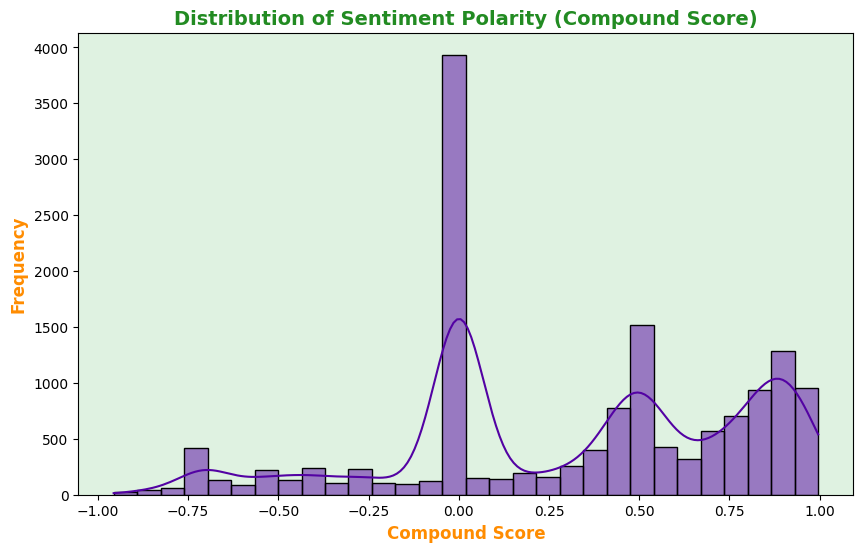

In [17]:
# Sentiment Polarity Distribution
# (The 'compound' score represents sentiment polarity)
plt.figure(figsize=(10, 6))
sns.histplot(df['compound'], bins=30, kde=True)
plt.title('Distribution of Sentiment Polarity (Compound Score)', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
plt.xlabel('Compound Score',fontsize = 12, fontweight = 'bold', color = 'darkorange')
plt.ylabel('Frequency',fontsize = 12, fontweight = 'bold', color = 'darkorange')
plt.gca().set_facecolor('#dff2e1')
plt.show()


Daily Sentiment Ratios:
 sentiment_type  Positive Ratio  Negative Ratio
date                                          
2022-12-01            0.800000        0.000000
2022-12-02            0.700000        0.100000
2022-12-03            0.789474        0.157895
2022-12-04            0.466667        0.200000
2022-12-05            0.428571        0.142857


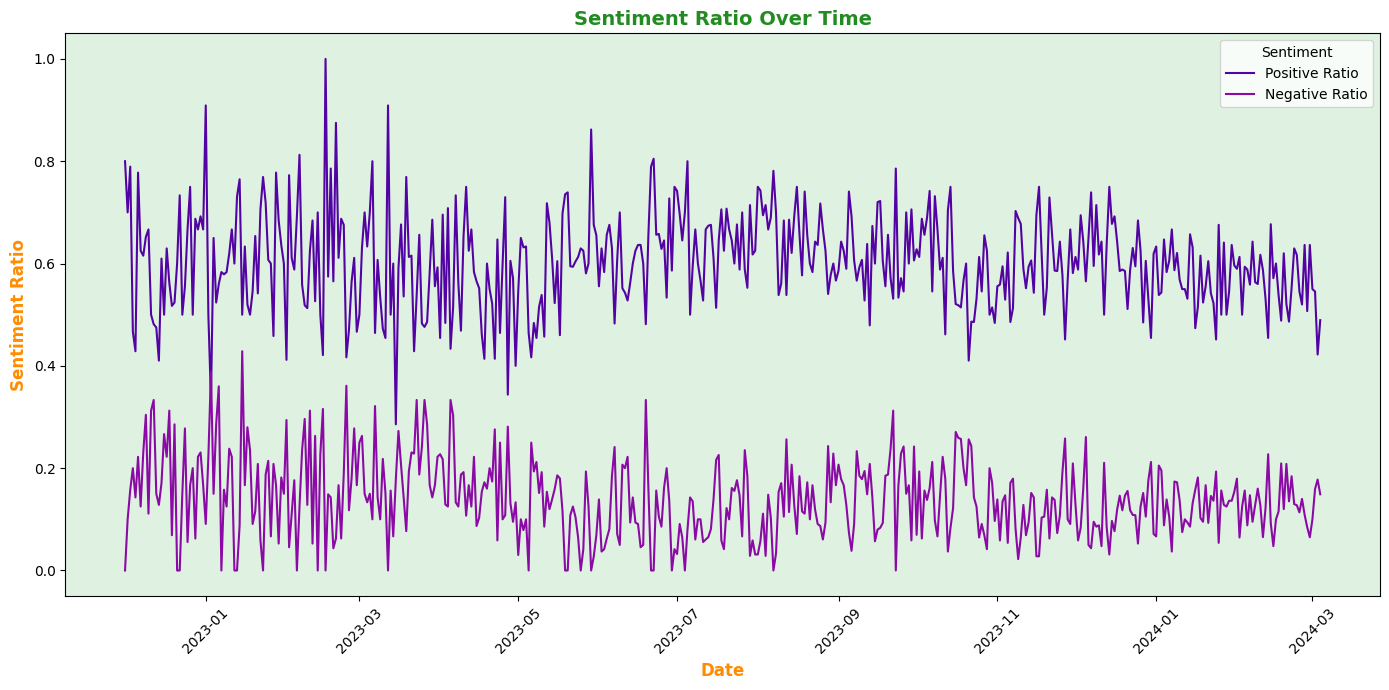

In [18]:
# Sentiment Ratio Over Time (Positive vs. Negative)
# Group by date and sentiment type
daily_sentiment = df.groupby(df['date'].dt.date)['sentiment_type'].value_counts().unstack(fill_value=0)

# Calculate total sentiment counts for each day
daily_sentiment['Total'] = daily_sentiment['POSITIVE'] + daily_sentiment['NEGATIVE'] + daily_sentiment['NEUTRAL']

# Calculate sentiment ratio
daily_sentiment['Positive Ratio'] = daily_sentiment['POSITIVE'] / daily_sentiment['Total']
daily_sentiment['Negative Ratio'] = daily_sentiment['NEGATIVE'] / daily_sentiment['Total']
print("Daily Sentiment Ratios:\n", daily_sentiment[['Positive Ratio', 'Negative Ratio']].head())

# Plot sentiment ratio trends
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment.index, daily_sentiment['Positive Ratio'], label='Positive Ratio')
plt.plot(daily_sentiment.index, daily_sentiment['Negative Ratio'], label='Negative Ratio')
plt.title('Sentiment Ratio Over Time', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
plt.xlabel('Date',fontsize = 12, fontweight = 'bold', color = 'darkorange')
plt.ylabel('Sentiment Ratio',fontsize = 12, fontweight = 'bold', color = 'darkorange')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().set_facecolor('#dff2e1')
plt.show()


Top 20 2-grams: [('binance killer', np.int64(3455)), ('bitcoin bullet', np.int64(3064)), ('bullet trading', np.int64(2607)), ('target target', np.int64(2428)), ('vip content', np.int64(2205)), ('tp tp', np.int64(1590)), ('top gainer', np.int64(1290)), ('target profit', np.int64(1227)), ('crypto market', np.int64(1177)), ('market analysis', np.int64(1137)), ('never miss', np.int64(1096)), ('miss another', np.int64(1094)), ('signal id', np.int64(1019)), ('price action', np.int64(989)), ('market update', np.int64(976)), ('vip market', np.int64(964)), ('short term', np.int64(935)), ('limit vip', np.int64(877)), ('message tmebkceo', np.int64(820)), ('market cap', np.int64(765))]


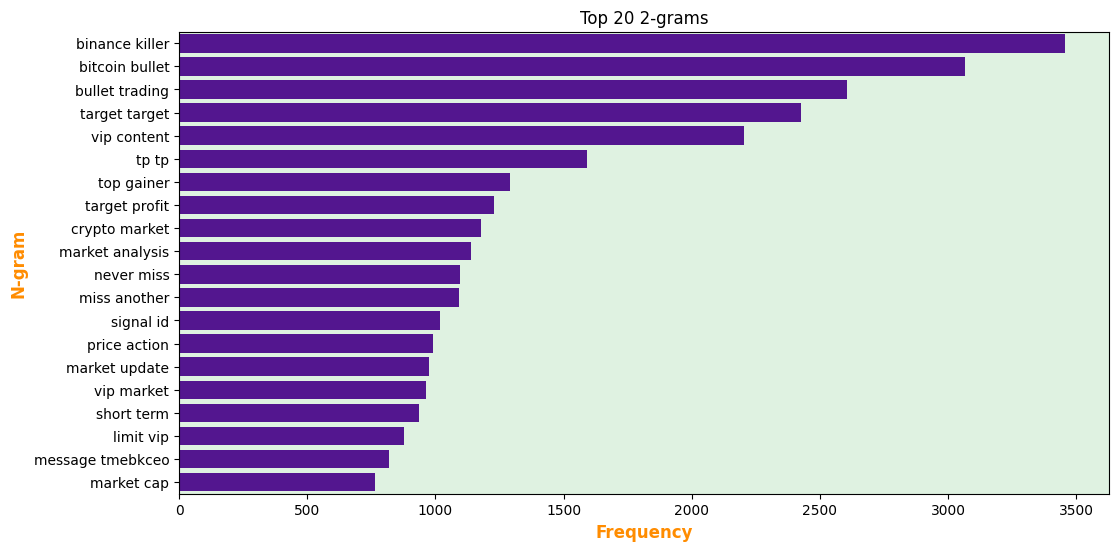

In [19]:
# Top N-grams (Bigrams) Analysis
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(text, n=2, top_n=20):
    """
    Plots the most frequent n-grams in a given text series.
    """
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_words = words_freq[:top_n]
    print(f"Top {top_n} {n}-grams:", top_words)
    df_top_words = pd.DataFrame(top_words, columns=['ngram', 'count'])
    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='ngram', data=df_top_words)
    plt.title(f'Top {top_n} {n}-grams')
    plt.xlabel('Frequency',fontsize = 12, fontweight = 'bold', color = 'darkorange')
    plt.ylabel('N-gram',fontsize = 12, fontweight = 'bold', color = 'darkorange')
    plt.gca().set_facecolor('#dff2e1')
    plt.show()

plot_top_ngrams(df['processed_text'], n=2, top_n=20)

Text Length Summary:
 count    14712.000000
mean        21.269168
std         22.797937
min          0.000000
25%          7.000000
50%         14.000000
75%         27.000000
max        306.000000
Name: processed_text, dtype: float64


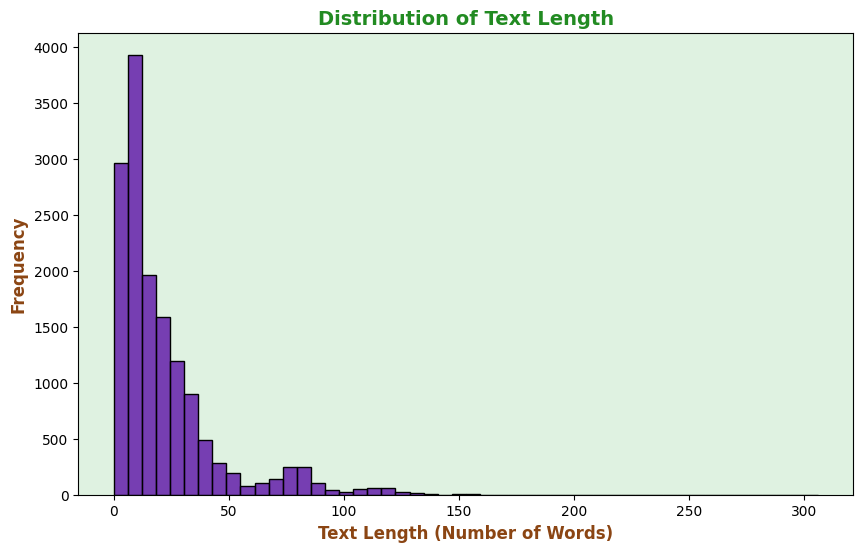

In [20]:
# Distribution of Text Length
text_length = df['processed_text'].apply(lambda x: len(x.split()))
print("Text Length Summary:\n", text_length.describe())
plt.figure(figsize=(10, 6))
sns.histplot(text_length, bins=50)
plt.title('Distribution of Text Length', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
plt.xlabel('Text Length (Number of Words)',fontsize = 12, fontweight = 'bold', color = 'saddlebrown')
plt.ylabel('Frequency',fontsize = 12, fontweight = 'bold', color = 'saddlebrown')
plt.gca().set_facecolor('#dff2e1')
plt.show()


In [21]:
# Using TF-IDF to convert text to numerical data.
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting features to 5000
X = tfidf_vectorizer.fit_transform(df['processed_text'])
y = df['sentiment_type']


In [22]:
# Split the Data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Multinomial Naive Bayes is suitable for text classification.
model = MultinomialNB()

In [24]:
model.fit(X_train, y_train)


MultinomialNB()

Accuracy: 0.8145
              precision    recall  f1-score   support

    NEGATIVE       0.73      0.58      0.65       408
     NEUTRAL       0.87      0.67      0.76       771
    POSITIVE       0.81      0.93      0.87      1764

    accuracy                           0.81      2943
   macro avg       0.80      0.73      0.76      2943
weighted avg       0.82      0.81      0.81      2943



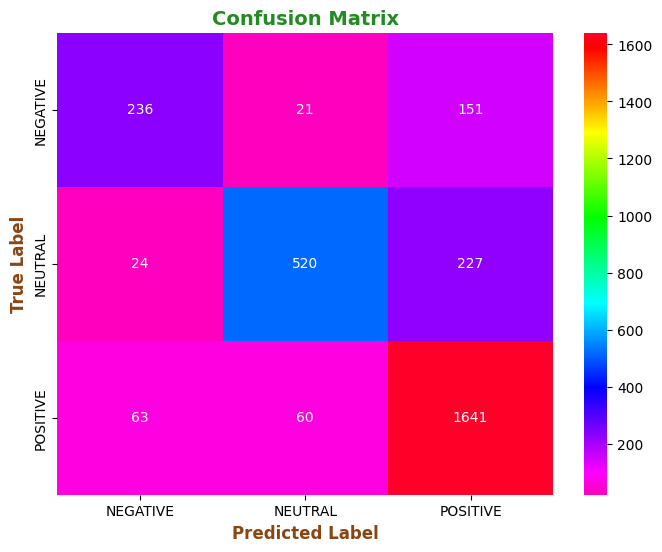

In [25]:
# Evaluate the Model:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='gist_rainbow_r', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
plt.xlabel('Predicted Label',fontsize = 12, fontweight = 'bold', color = 'saddlebrown')
plt.ylabel('True Label',fontsize = 12, fontweight = 'bold', color = 'saddlebrown')
plt.gca().set_facecolor('#dff2e1')
plt.show()

In [26]:
# Hyperparameter Tuning for TF-IDF
from sklearn.model_selection import GridSearchCV
# Define parameter grid
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}
# Setup grid search
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=3, scoring='accuracy')
# Fit grid search to the data
grid_search.fit(X_train, y_train)
# Print best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'alpha': 0.1}
Best score found:  0.8201206559605744


In [27]:
# Use the best estimator found by grid search
best_model = grid_search.best_estimator_

# Evaluate the Model:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


Accuracy: 0.8332
              precision    recall  f1-score   support

    NEGATIVE       0.63      0.72      0.67       408
     NEUTRAL       0.90      0.73      0.81       771
    POSITIVE       0.86      0.90      0.88      1764

    accuracy                           0.83      2943
   macro avg       0.80      0.78      0.79      2943
weighted avg       0.84      0.83      0.83      2943




--- Multinomial Naive Bayes with Hyperparameter Tuning ---
Best parameters found:  {'alpha': 0.1}
Best score found:  0.8201206559605744
Accuracy: 0.8332
              precision    recall  f1-score   support

    NEGATIVE       0.63      0.72      0.67       408
     NEUTRAL       0.90      0.73      0.81       771
    POSITIVE       0.86      0.90      0.88      1764

    accuracy                           0.83      2943
   macro avg       0.80      0.78      0.79      2943
weighted avg       0.84      0.83      0.83      2943



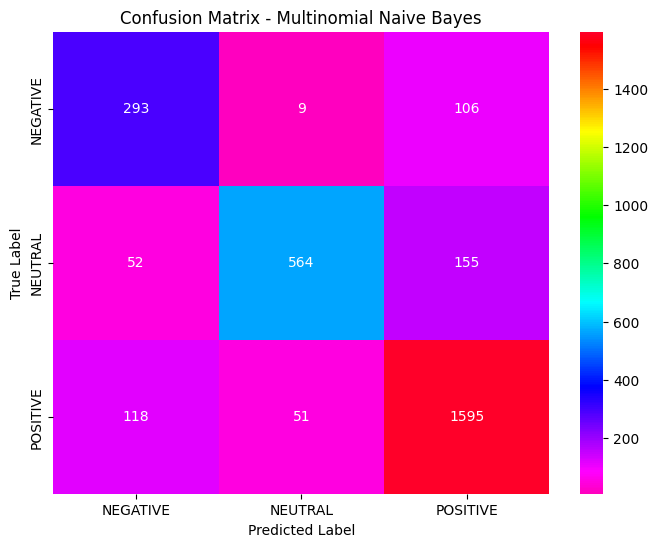

In [28]:
# --- Model Tuning and Comparison ---

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluates a model and plots the confusion matrix."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='gist_rainbow_r', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# 1. Multinomial Naive Bayes with Hyperparameter Tuning

print("\n--- Multinomial Naive Bayes with Hyperparameter Tuning ---")

param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_nb.fit(X_train, y_train)

print("Best parameters found: ", grid_search_nb.best_params_)
print("Best score found: ", grid_search_nb.best_score_)

best_model_nb = grid_search_nb.best_estimator_
evaluate_model(best_model_nb, X_test, y_test, "Multinomial Naive Bayes")



--- Logistic Regression with Hyperparameter Tuning ---
Best parameters found:  {'C': 100}
Best score found:  0.9233579743393662
Accuracy: 0.9388
              precision    recall  f1-score   support

    NEGATIVE       0.89      0.82      0.85       408
     NEUTRAL       0.92      0.95      0.93       771
    POSITIVE       0.96      0.96      0.96      1764

    accuracy                           0.94      2943
   macro avg       0.92      0.91      0.92      2943
weighted avg       0.94      0.94      0.94      2943



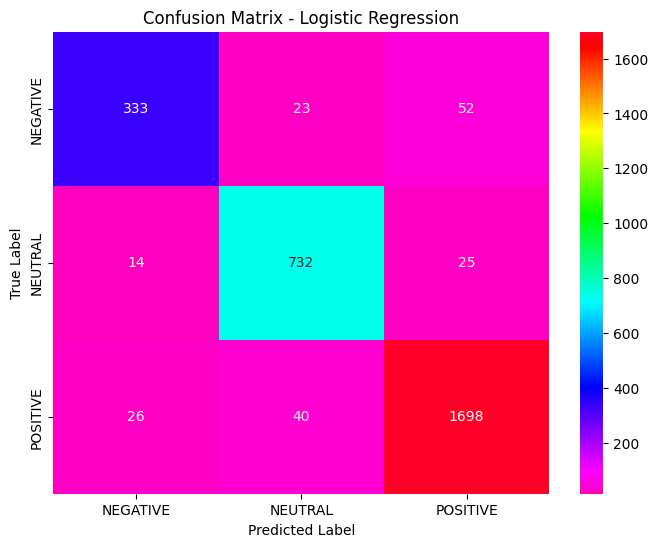

Best parameters found:  {'C': 100}
Best score found:  0.9233579743393662
Accuracy: 0.9388
              precision    recall  f1-score   support

    NEGATIVE       0.89      0.82      0.85       408
     NEUTRAL       0.92      0.95      0.93       771
    POSITIVE       0.96      0.96      0.96      1764

    accuracy                           0.94      2943
   macro avg       0.92      0.91      0.92      2943
weighted avg       0.94      0.94      0.94      2943



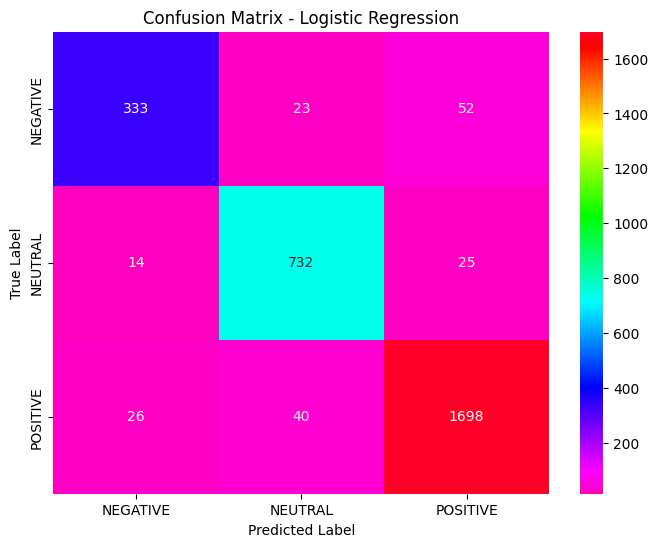

In [30]:
print("\n--- Logistic Regression with Hyperparameter Tuning ---")

param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000, solver='liblinear'), param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best parameters found: ", grid_search_lr.best_params_)
print("Best score found: ", grid_search_lr.best_score_)

best_model_lr = grid_search_lr.best_estimator_
evaluate_model(best_model_lr, X_test, y_test, "Logistic Regression")

param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000, solver='liblinear'), param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best parameters found: ", grid_search_lr.best_params_)
print("Best score found: ", grid_search_lr.best_score_)

best_model_lr = grid_search_lr.best_estimator_
evaluate_model(best_model_lr, X_test, y_test, "Logistic Regression")



--- Support Vector Machine (SVM) with Hyperparameter Tuning ---
Best parameters found:  {'C': 10, 'kernel': 'linear'}
Best score found:  0.9192794629960064
Accuracy: 0.9378
              precision    recall  f1-score   support

    NEGATIVE       0.85      0.85      0.85       408
     NEUTRAL       0.93      0.95      0.94       771
    POSITIVE       0.96      0.95      0.96      1764

    accuracy                           0.94      2943
   macro avg       0.91      0.92      0.91      2943
weighted avg       0.94      0.94      0.94      2943



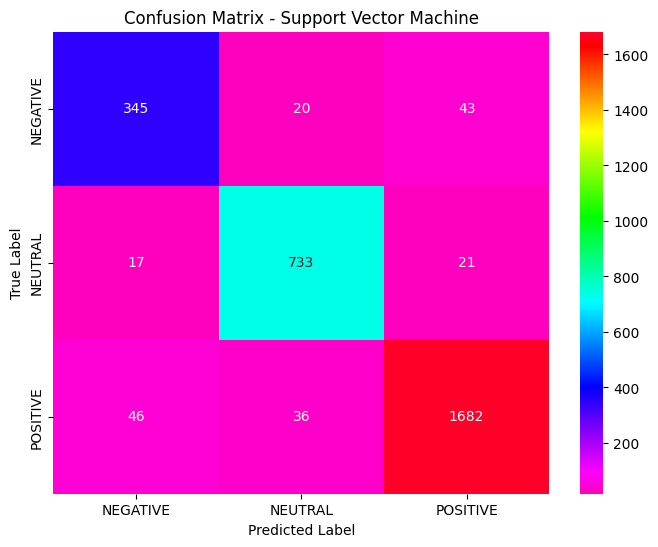

In [31]:
# 3. Support Vector Machine (SVM) with Hyperparameter Tuning

print("\n--- Support Vector Machine (SVM) with Hyperparameter Tuning ---")

param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best parameters found: ", grid_search_svm.best_params_)
print("Best score found: ", grid_search_svm.best_score_)

best_model_svm = grid_search_svm.best_estimator_
evaluate_model(best_model_svm, X_test, y_test, "Support Vector Machine")



--- TF-IDF Tuning Example ---
Best parameters found:  {'max_df': 0.5, 'min_df': 1, 'ngram_range': (1, 1)}
Best score found:  nan
Accuracy: 0.8009
              precision    recall  f1-score   support

    NEGATIVE       0.88      0.42      0.57       408
     NEUTRAL       0.90      0.62      0.73       771
    POSITIVE       0.77      0.97      0.86      1764

    accuracy                           0.80      2943
   macro avg       0.85      0.67      0.72      2943
weighted avg       0.82      0.80      0.79      2943



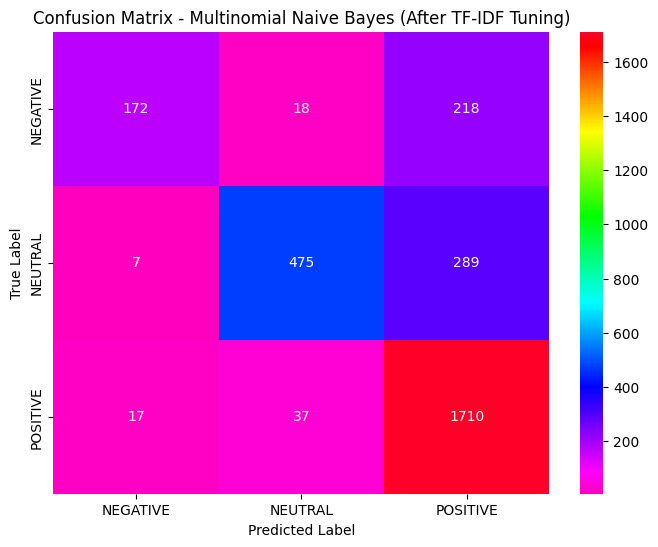

In [32]:
# --- TF-IDF Tuning Example ---
print("\n--- TF-IDF Tuning Example ---")

param_grid_tfidf = {
    'max_df': [0.5, 0.75, 1.0],
    'min_df': [1, 2, 3],
    'ngram_range': [(1, 1), (1, 2)]  # Unigrams and bigrams
}

grid_search_tfidf = GridSearchCV(TfidfVectorizer(), param_grid_tfidf, cv=3, scoring='accuracy') # remove n_jobs as it is not applicable
grid_search_tfidf.fit(df['processed_text'], y)  # Fit on the whole data before splitting

print("Best parameters found: ", grid_search_tfidf.best_params_)
print("Best score found: ", grid_search_tfidf.best_score_)

# Rebuild data matrix with optimized TF-IDF
best_tfidf = grid_search_tfidf.best_estimator_
X = best_tfidf.fit_transform(df['processed_text'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Retrain model with optimized TF-IDF vectors
best_model_nb = MultinomialNB()  # You can train other models, too
best_model_nb.fit(X_train, y_train)

evaluate_model(best_model_nb, X_test, y_test, "Multinomial Naive Bayes (After TF-IDF Tuning)")

#  Word Cloud Visualization
def generate_word_cloud(text):
    """
    Generates and displays a word cloud from the given text.
    """
    # Check if the text list is empty
    if not text:
        print("No text available to generate word cloud.")
        return None  # Return None if no text
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(' '.join(text)))  # Join the series into a single string
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Social Media Posts', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
    plt.show()
    return True # return True if wordcloud is generated



In [33]:
import pickle
import joblib  #Alternative to pickle

# --- Deploy the Model (Optional) ---
# Save the Model and TF-IDF Vectorizer
try:
    joblib.dump(best_model_nb, 'best_model_nb.joblib')  # Save the best Naive Bayes model
    joblib.dump(best_tfidf, 'best_tfidf.joblib')      # Save the best TF-IDF vectorizer
    print("\nModel and TF-IDF vectorizer saved to best_model_nb.joblib and best_tfidf.joblib")
except Exception as e:
    print(f"An error occurred while saving the model or TF-IDF vectorizer: {e}")

# **Example of Loading the Model and TF-IDF Vectorizer (for demonstration)**
try:
    loaded_model_nb = joblib.load('best_model_nb.joblib')  # Load the model
    loaded_tfidf = joblib.load('best_tfidf.joblib')      # Load the TF-IDF vectorizer
    print("Model and TF-IDF vectorizer loaded successfully.")

    # Example usage with new data
    new_text = ["Absolutely fantastic experience — exceeded my expectations!"]
    new_text_vectorized = loaded_tfidf.transform(new_text) # Use the loaded TF-IDF
    prediction = loaded_model_nb.predict(new_text_vectorized)   # Use the loaded model
    print(f"Predicted sentiment: {prediction}")

except Exception as e:
    print(f"An error occurred while loading the model or TF-IDF vectorizer: {e}")



Model and TF-IDF vectorizer saved to best_model_nb.joblib and best_tfidf.joblib
Model and TF-IDF vectorizer loaded successfully.
Predicted sentiment: ['POSITIVE']


In [35]:
def predict_sentiment(review, vectorizer, model):
    """
    Predicts sentiment of a custom review using trained TF-IDF vectorizer and model.
    """
    # If any preprocessing is needed, do it here (e.g., lowercasing, removing special chars)
    processed = review.lower()

    # Vectorize the review
    review_vector = vectorizer.transform([processed])

    # Predict sentiment
    prediction = model.predict(review_vector)[0]

    # Display result
    print(f"\nReview: {review}")
    print(f"Predicted Sentiment: {prediction}")


In [36]:
my_review = "I'm really happy with this product! Works like a charm 🔥"
predict_sentiment(my_review, best_tfidf, best_model_nb)



Review: I'm really happy with this product! Works like a charm 🔥
Predicted Sentiment: POSITIVE


In [41]:
my_review1 = "I'm really fear with this product! "
predict_sentiment(my_review1, best_tfidf, best_model_nb)


Review: I'm really fear with this product! 
Predicted Sentiment: NEGATIVE
